<h3> BERT classifier v5 trained on balanced data for male/female in neutral class, label = gender, tested gender predictions for neutral class</h3>
<p>Using code from: https://mccormickml.com/2019/07/22/BERT-fine-tuning/</p>

In [ ]:
# import libraries
import pandas as pd
import numpy as np
#!conda install -y tensorflow
#!conda install -y pytorch torchvision -c pytorch
#!pip install transformers
import tensorflow as tf
import torch

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read files and create dataframe
toxicity_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxicity_annotated_comments.tsv', sep = '\t', index_col = 0)
toxicity_annotations = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxicity_annotations.tsv',  sep = '\t')
toxicity_demographics = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxicity_worker_demographics.tsv', sep = '\t')

toxicity = toxicity_comments.merge(toxicity_annotations, how ='outer', on="rev_id")
toxicity = toxicity.merge(toxicity_demographics, how ='outer', on="worker_id").sort_values(by=['rev_id','worker_id'])

# remove newline and tab tokens
toxicity['comment'] = toxicity['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
toxicity['comment'] = toxicity['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

# add binary gender columns
toxicity = toxicity[toxicity['gender']!='other']
toxicity = pd.concat([toxicity, pd.get_dummies(toxicity.gender).rename(columns = "{}_binary".format)], axis = 1)

# limit size of dataset for testing purposes
very_toxic = toxicity[toxicity.toxicity_score == -2.0]
toxic = toxicity[toxicity.toxicity_score == -1.0]
neutral = toxicity[toxicity.toxicity_score == 0.0]
nontoxic = toxicity[toxicity.toxicity_score == 1.0]
healthy = toxicity[toxicity.toxicity_score == 2.0]

female_neutral = neutral[neutral.female_binary == 1]
male_neutral = neutral[neutral.male_binary == 1]

# size = min(female_neutral.shape[0],male_neutral.shape[0])
# print(size)
size = 25000

neutral_data = pd.concat([female_neutral.sample(size), male_neutral.sample(size)])
neutral_data = neutral_data.sample(frac=1)
print(neutral_data.shape[0])
test_data = neutral_data.sample(frac = 0.2)
print(test_data.shape[0])
neutral_data = neutral_data.drop(test_data.index)

print(neutral_data.shape[0])
display (neutral_data.head(5))

50000
10000
40000


,rev_id,comment,year,logged_in,ns,sample,split,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education,female_binary,male_binary
360332,1.38e+07,"New comments at bottom, please. ==Complaints==",2005,False,article,random,train,2892,0,0.0,female,0.0,18-30,masters,1,0
631174,6.64e+08,":Thanks, I will watch for this in the future....",2015,True,user,random,train,1037,0,0.0,female,0.0,45-60,hs,1,0
1354949,8.10e+07,` PLease do not add third party companies to ...,2006,True,user,random,train,1460,0,0.0,female,0.0,45-60,masters,1,0
366118,2.60e+08,== 1 more thing == I noticed plenty of gram...,2008,True,user,blocked,train,3439,0,0.0,female,0.0,30-45,bachelors,1,0
1499681,7.64e+07,"` :::::::First, trying to pull ``rank`` with m...",2006,True,article,blocked,dev,2608,0,0.0,male,0.0,18-30,hs,0,1


In [ ]:
# try to use gpu
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# extract relevant information
comments = neutral_data.comment.values
labels = neutral_data.female_binary.values

In [ ]:
! pip install transformers==3.5.1
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 250,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# # Print sentence 0, now as a list of IDs.
# print('Original: ', comments[0],scores[0])
# print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

36,000 training samples
4,000 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size
)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# # Tell pytorch to run this model on the GPU.
model.cuda()
#model.cpu()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be misled--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels.long())

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels.long())
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,250.    Elapsed: 0:00:27.
  Batch    80  of  2,250.    Elapsed: 0:00:55.
  Batch   120  of  2,250.    Elapsed: 0:01:23.
  Batch   160  of  2,250.    Elapsed: 0:01:52.
  Batch   200  of  2,250.    Elapsed: 0:02:21.
  Batch   240  of  2,250.    Elapsed: 0:02:51.
  Batch   280  of  2,250.    Elapsed: 0:03:20.
  Batch   320  of  2,250.    Elapsed: 0:03:50.
  Batch   360  of  2,250.    Elapsed: 0:04:20.
  Batch   400  of  2,250.    Elapsed: 0:04:51.
  Batch   440  of  2,250.    Elapsed: 0:05:21.
  Batch   480  of  2,250.    Elapsed: 0:05:52.
  Batch   520  of  2,250.    Elapsed: 0:06:22.
  Batch   560  of  2,250.    Elapsed: 0:06:53.
  Batch   600  of  2,250.    Elapsed: 0:07:24.
  Batch   640  of  2,250.    Elapsed: 0:07:54.
  Batch   680  of  2,250.    Elapsed: 0:08:25.
  Batch   720  of  2,250.    Elapsed: 0:08:56.
  Batch   760  of  2,250.    Elapsed: 0:09:27.
  Batch   800  of  2,250.    Elapsed: 0:09:58.
  Batch   840  of

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.70,0.69,0.50,0:28:29,0:01:10
2,0.69,0.69,0.50,0:28:43,0:01:11
3,0.69,0.69,0.51,0:28:46,0:01:10


testing on female
Number of test sentences: 4,986



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



Predicting labels for 4,986 test sentences...
    DONE.
Total F1: 0.337
Accuracy: 0.20


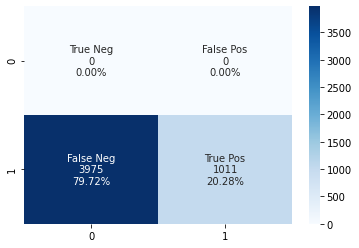

testing on male
Number of test sentences: 5,014



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



Predicting labels for 5,014 test sentences...
    DONE.
Total F1: 0.000
Accuracy: 0.81


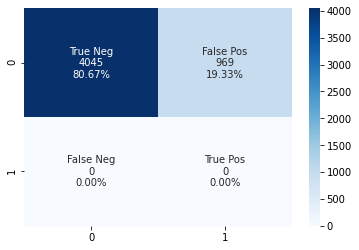

In [ ]:
# create test set

correct_female_pred = []
correct_male_pred = []
accuracies = []
for i in range(2):
  if i == 0:
    df = test_data[test_data.female_binary==1]
    print('testing on female')
  else:
    df = test_data[test_data.female_binary==0]
    print('testing on male')

  df = df.sample(frac=1)
  print('Number of test sentences: {:,}\n'.format(df.shape[0]))

  comments = df.comment.values
  labels = df.female_binary.values

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for cmt in comments:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          cmt,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 250,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Set the batch size.  
  batch_size = 16

  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  # Prediction on test set

  print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  print('    DONE.')

  from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
  import seaborn as sns
  import matplotlib.pyplot as plt
  
  # Combine the results across all batches. 
  flat_pred = np.concatenate(predictions, axis=0)
  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_pred, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  for i in range(len(flat_true_labels)):
    if flat_true_labels[i]==flat_predictions[i]:
      if flat_true_labels[i] == 1:
        correct_female_pred.append(tuple(flat_pred[i]))
      else:
        correct_male_pred.append(tuple(flat_pred[i]))

  f1 = f1_score(flat_true_labels, flat_predictions)
  print('Total F1: %.3f' % f1)
  acc = accuracy_score(flat_true_labels,flat_predictions)
  print('Accuracy: %.2f' % acc)
  accuracies.append(acc)

  cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()
  except ValueError:
    print("could not display")

  # f1_set = []

  # # Evaluate each test batch
  # print('Calculating and F1 score for each batch...')

  # # For each input batch...
  # for i in range(len(true_labels)):
    
  #   # The predictions for this batch are a 2-column ndarray (one column for "0" 
  #   # and one column for "1"). Pick the label with the highest value and turn this
  #   # in to a list of 0s and 1s.
  #   pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    
  #   # Calculate and store the coef for this batch.  
  #   score = f1_score(true_labels[i], pred_labels_i)
  #   f1_set.append(score)

  # # Create a barplot showing the f1 score for each batch of test samples.
  # ax = sns.barplot(x=list(range(len(f1_set))), y=f1_set, ci=None)

  # plt.title('f1 Score per Batch')
  # plt.ylabel('f1 Score (0 to +1)')
  # plt.xlabel('Batch #')

  # plt.show()

In [ ]:
import plotly.graph_objects as go

unzipped_object = zip(*correct_female_pred)
unzipped_list = list(unzipped_object)

fig = go.Figure(data=go.Scatter(x=unzipped_list[1],
                                y=unzipped_list[0],
                                mode='markers'))

fig.update_layout(title='Likelihood of genders for true positive (female)',
                  xaxis_title="Likelihood female",
                  yaxis_title="Likelihood male")
fig.show()

unzipped_object = zip(*correct_male_pred)
unzipped_list = list(unzipped_object)

fig = go.Figure(data=go.Scatter(x=unzipped_list[0],
                                y=unzipped_list[1],
                                mode='markers'))

fig.update_layout(title='Likelihood of genders for true negative (male)',
                  xaxis_title="Likelihood male",
                  yaxis_title="Likelihood female")
fig.show()